In [1]:
%matplotlib inline
import os,sys
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import pytorchnet

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

0.4.1


(1000, 2)


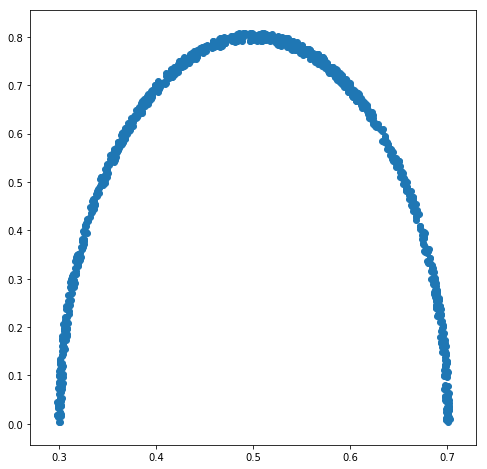

In [7]:
def generateSemicircle(numPoints,meanRadius,radVar):
    theta=np.random.rand(numPoints)*np.pi
    rho=np.random.uniform(-radVar,radVar,(numPoints,))+meanRadius
    return np.stack([np.cos(theta)*rho*0.25+0.5,np.sin(theta)*rho],1)


def generateLine(numPoints,noiseScale):
    m=np.random.rand()*10
    b=np.random.rand()*10
    x=np.linspace(0.1,0.9,numPoints)
    y=(x*m+b)+np.random.normal(scale=noiseScale,size=(numPoints,))
    return np.stack([x,y/(y.max()*1.1)],1)


pts=generateSemicircle(1000,0.8,0.01)
# pts=generateLine(1000,0.05)

print(pts.shape)

fig=plt.figure(figsize=[8,8])
plt.scatter(pts[:,0],pts[:,1])

In [3]:
lvae=pytorchnet.DenseVAE(4,6,3,[10,5],[15,10])
print(lvae)

t=torch.randn(10,4)
d,mu,logvar,z=lvae(t)
print(d.shape,z.shape)

DenseVAE(
  (encode): Sequential(
    (encode_0): Sequential(
      (0): Linear(in_features=4, out_features=10, bias=True)
      (1): Dropout(p=0)
      (2): PReLU(num_parameters=1)
    )
    (encode_1): Sequential(
      (0): Linear(in_features=10, out_features=5, bias=True)
      (1): Dropout(p=0)
      (2): PReLU(num_parameters=1)
    )
  )
  (decode): Sequential(
    (decode0): Sequential(
      (0): Linear(in_features=5, out_features=15, bias=True)
      (1): Dropout(p=0)
      (2): PReLU(num_parameters=1)
    )
    (decode1): Sequential(
      (0): Linear(in_features=15, out_features=10, bias=True)
      (1): Dropout(p=0)
      (2): PReLU(num_parameters=1)
    )
    (final): Linear(in_features=10, out_features=6, bias=True)
  )
  (mu): Linear(in_features=5, out_features=3, bias=True)
  (logvar): Linear(in_features=5, out_features=3, bias=True)
  (decodeL): Linear(in_features=3, out_features=5, bias=True)
)
torch.Size([10, 6]) torch.Size([10, 3])


In [4]:
xt=torch.from_numpy(pts).float()
yt=torch.from_numpy(pts).float()

net=pytorchnet.DenseVAE(xt.shape[1],yt.shape[1],2,[20,20,20],[20,20,20])


# MSE makes sense for regression, adjust beta until L1 loss between pred and yt goes down
loss=pytorchnet.KLDivLoss(torch.nn.MSELoss(),beta=1e-6) 
loss1=torch.nn.L1Loss()
opt=torch.optim.Adam(net.parameters())

iters=10000

for i in range(iters):
    opt.zero_grad()
    pred,mu,logvar,z=net(xt)
    lossval=loss(pred,yt,mu,logvar)
    l1=loss1(pred,yt)
    
    lossval.backward()
    opt.step()
    
    if i%(iters//10)==0:
        print(i,lossval.item(),l1.item(),z.min().item(),z.max().item())

0 0.04526760056614876 0.18253886699676514 -3.346903085708618 3.820246696472168
1000 0.007731840014457703 0.05084610357880592 -3.1219820976257324 2.817469358444214
2000 0.003619368653744459 0.01853642612695694 -2.4727320671081543 2.264158010482788
3000 0.0034762914292514324 0.017358841374516487 -2.6200947761535645 2.567734956741333
4000 0.003547144588083029 0.017776964232325554 -2.5723540782928467 2.1857545375823975
5000 0.003443546360358596 0.016610195860266685 -2.512746810913086 2.2479312419891357
6000 0.0034820358268916607 0.016472259536385536 -2.6887927055358887 2.9324543476104736
7000 0.0034411149099469185 0.01663297414779663 -2.6158032417297363 2.5964431762695312
8000 0.0035176421515643597 0.01720322296023369 -3.1125268936157227 2.499385356903076
9000 0.0033657923340797424 0.016321148723363876 -2.493136167526245 2.3671576976776123


Text(0.5,1,'Latent Space Z From Last Training Step')

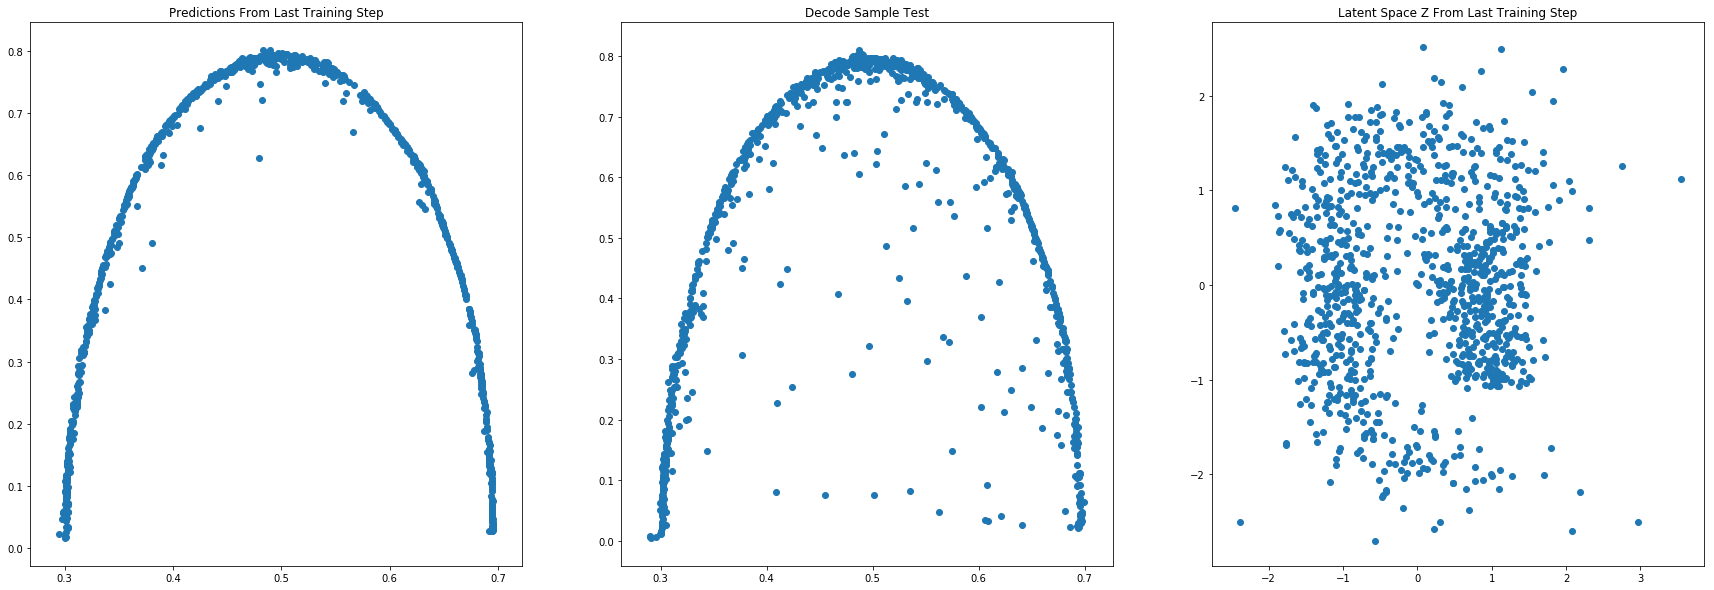

In [5]:
with torch.no_grad():
    net.eval()
    xtest=torch.zeros((1000,2),dtype=torch.float32).normal_(0,1)
    test=net.decodeForward(xtest)

fig,axes=plt.subplots(1,3,figsize=[30,10])
axes[0].scatter(pred[:,0].tolist(),pred[:,1].tolist())
axes[0].set_title('Predictions From Last Training Step')

axes[1].scatter(test[:,0].tolist(),test[:,1].tolist())
axes[1].set_title('Decode Sample Test')

axes[2].scatter(z[:,0].tolist(),z[:,1].tolist())
axes[2].set_title('Latent Space Z From Last Training Step')